In [1]:
# | tags: [parameters]
subject = "101"

In [2]:
# | tags: [parameters]
# Injected Parameters
subject = 137


In [3]:
import mne
from mne.preprocessing import ICA
import autoreject
from pathlib import Path
import pandas as pd
from datetime import datetime
import json
import os

from spectral.utils import print_date_time, read_parameters, config_project
from spectral.ica import compute_ica
from spectral.viz import plot_step, plot_bad_channels, plot_epochs
from spectral.specparam import specparam2pandas


config = read_parameters()
my_paths = config_project(subject)
project_path = my_paths["project_path"]
figures_path = my_paths["figures_path"]
specparam_path = my_paths["specparam_path"]

Path(specparam_path).mkdir(parents=True, exist_ok=True)

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")
print_date_time()

Using matplotlib as 2D backend.


2024-05-02 00:15:55


# Start raport


Opening raw data file /Users/daniel/PhD/Projects/psd-path/analysis/sub-137_filtered_raw.fif...


    Range : 750 ... 77078 =      3.000 ...   308.312 secs


Ready.


Reading 0 ... 76328  =      0.000 ...   305.312 secs...


Embedding : jquery-3.6.0.min.js


Embedding : bootstrap.bundle.min.js


Embedding : bootstrap.min.css


Embedding : bootstrap-table/bootstrap-table.min.js


Embedding : bootstrap-table/bootstrap-table.min.css


Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js


Embedding : bootstrap-table/bootstrap-table-export.min.js


Embedding : bootstrap-table/tableExport.min.js


Embedding : bootstrap-icons/bootstrap-icons.mne.min.css


Embedding : highlightjs/highlight.min.js


Embedding : highlightjs/atom-one-dark-reasonable.min.css


Effective window size : 8.192 (s)


Plotting power spectral density (dB=True).


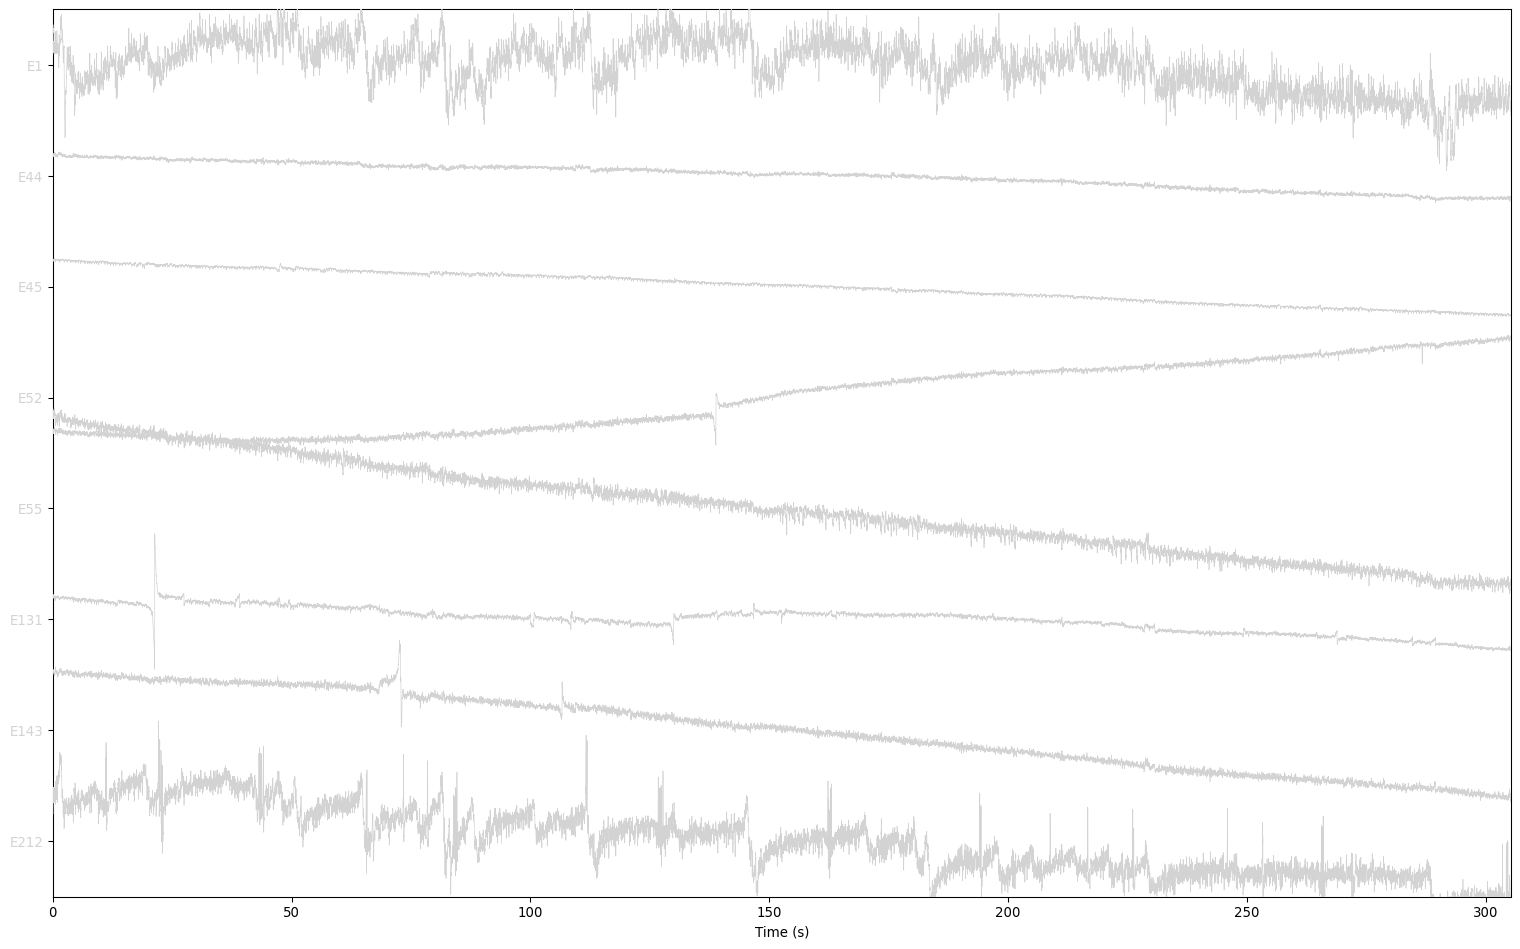

In [4]:
clean_raw = mne.io.read_raw_fif(
    f"{project_path}/analysis/sub-{subject}_filtered_raw.fif", preload=True
)
report = mne.Report(title=f"Report for subject {subject}", subject=subject)
report.add_raw(
    raw=clean_raw, title="Raw", psd=True, butterfly=True, scalings="auto"
)  # omit PSD plot
total_duration = clean_raw.times[-1]

try:
    # Add bad channels plot
    bad_channel_plot = clean_raw.plot(
        picks=clean_raw.info["bads"],
        duration=total_duration,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
    report.add_figure(bad_channel_plot, title="Rejected bad channels")
except Exception as e:
    print(f"An error occurred: {e}")

# ICA


ICA should be applied before the spatial interpolation of the non-functional channels.


In [5]:
epochs_good = mne.read_epochs(
    f"{project_path}/analysis/sub-{subject}_good_epochs-epo.fif"
)
ica = compute_ica(epochs_good, n_components=0.99, method="picard")


print(ica.n_components_)
if ica.n_components_ > 50:
    ica = compute_ica(epochs_good, n_components=50, method="picard")
ica.save(f"{project_path}/analysis/sub-{subject}_my_ica_model-ica.fif", overwrite=True)

Reading /Users/daniel/PhD/Projects/psd-path/analysis/sub-137_good_epochs-epo.fif ...


    Found the data of interest:


        t =       0.00 ...    5000.00 ms


        0 CTF compensation matrices available


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


Fitting ICA to data using 196 channels (please be patient, this may take a while)


Selecting by explained variance: 10 components


Fitting ICA took 2.8s.


10
Overwriting existing file.


Writing ICA solution to /Users/daniel/PhD/Projects/psd-path/analysis/sub-137_my_ica_model-ica.fif...


<ICA | epochs decomposition, method: picard (fit in 33 iterations on 106335 samples), 10 ICA components (196 PCA components available), channel types: eeg, no sources marked for exclusion>

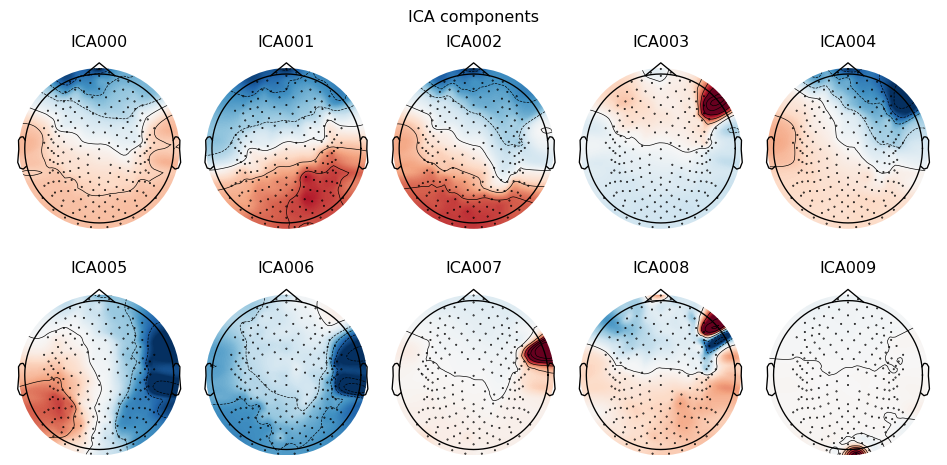

In [6]:
ica_plot_components = ica.plot_components()

Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


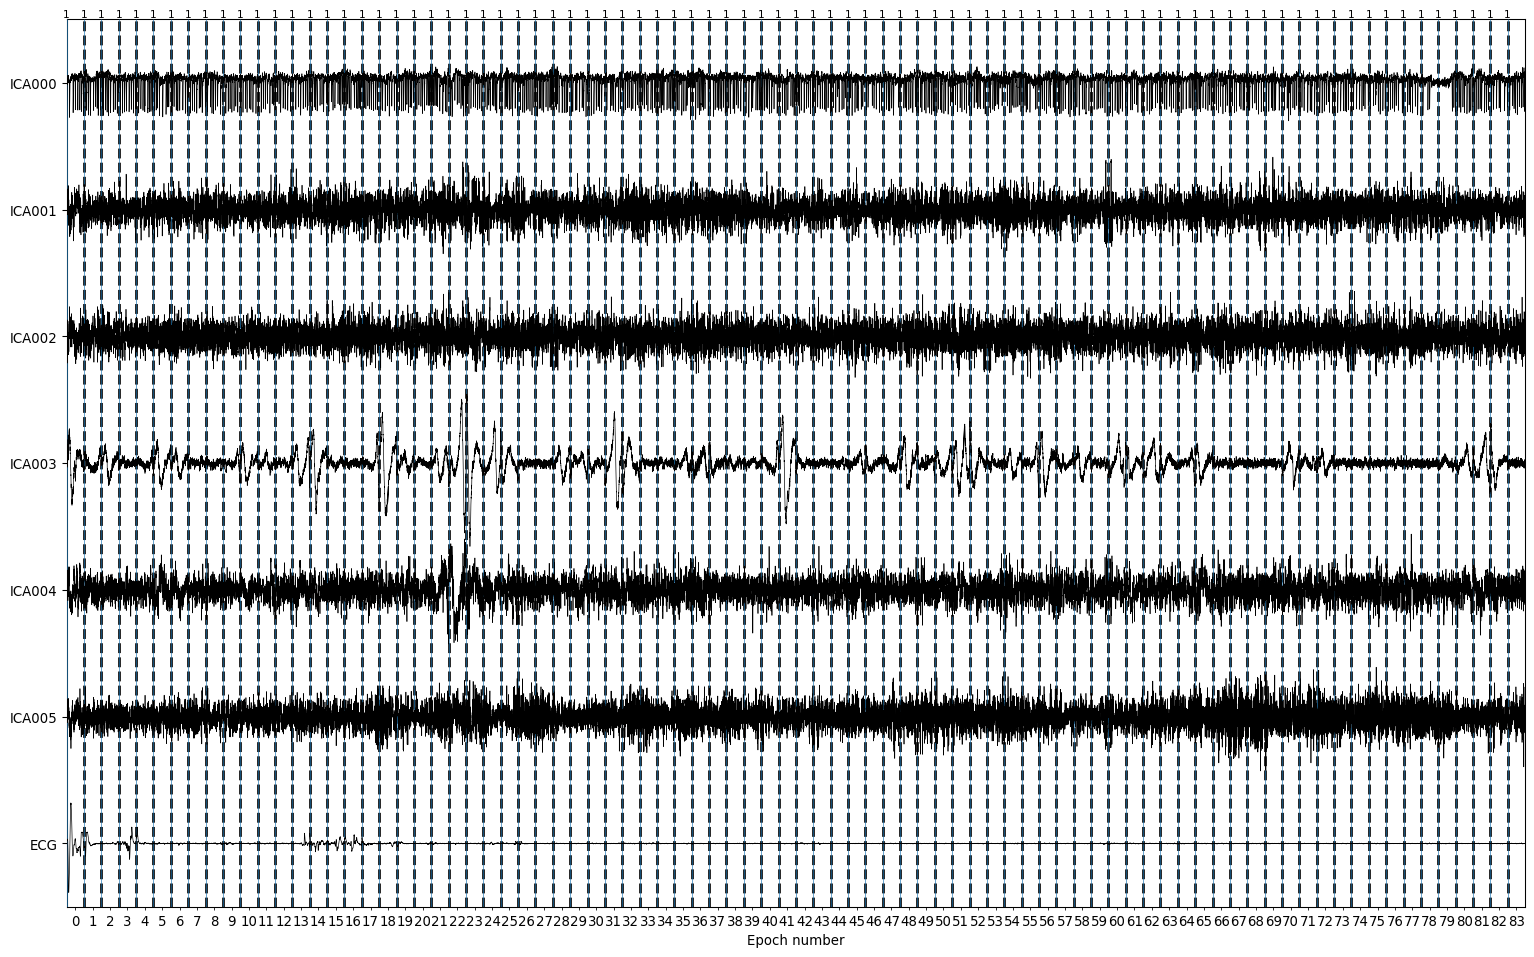

Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


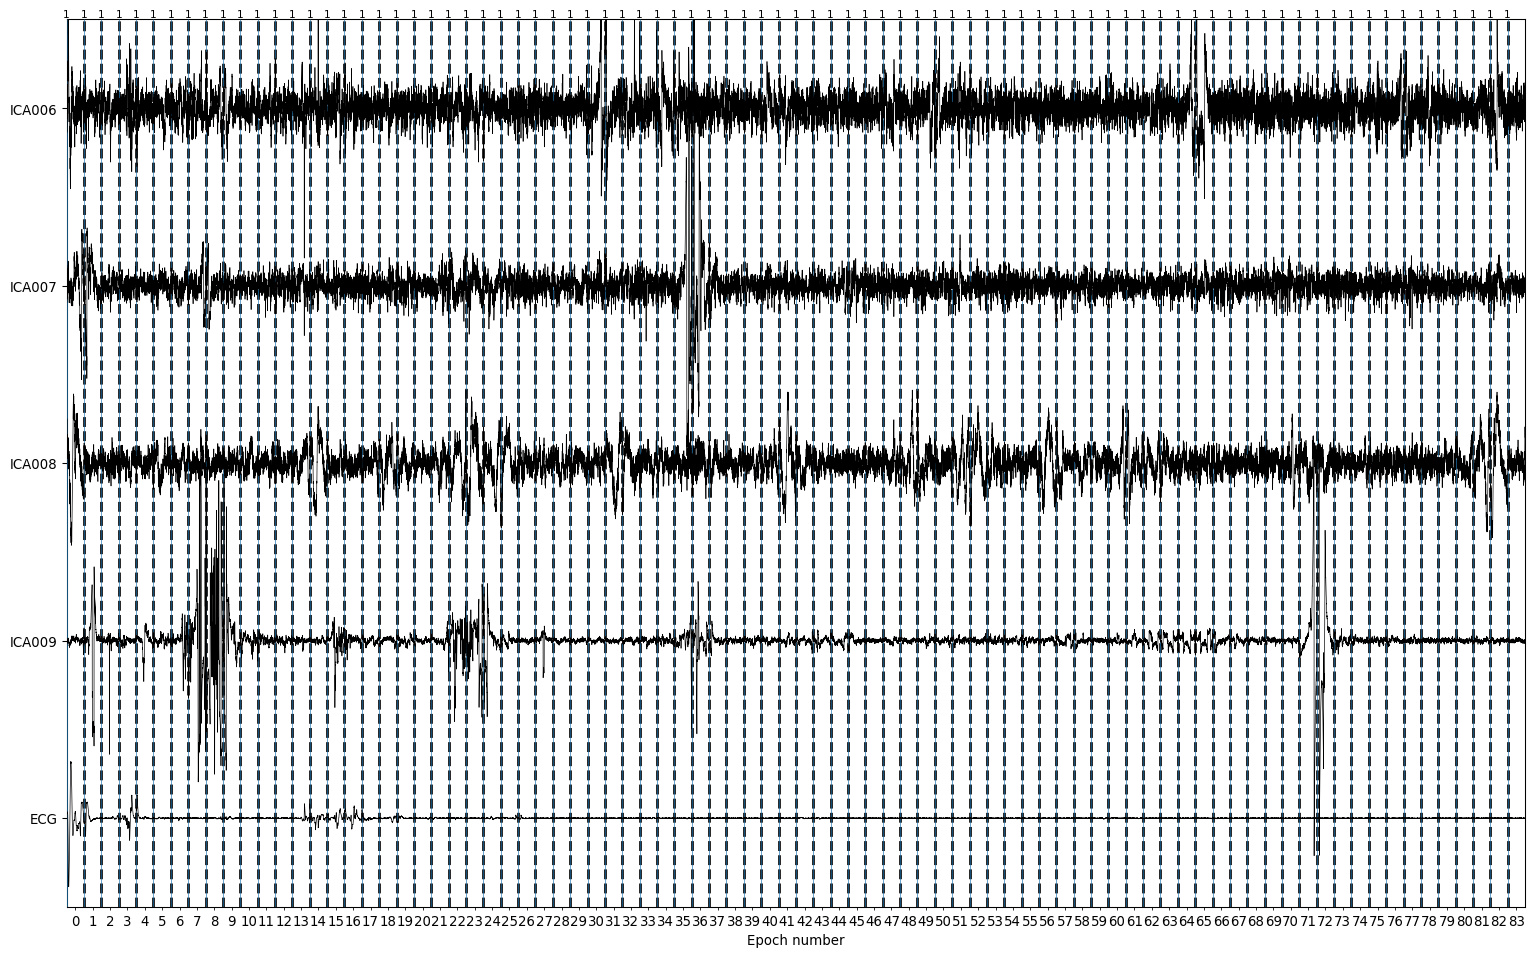

In [7]:
chunk_size = 6
chunks = [
    range(i, min(i + chunk_size, ica.n_components_))
    for i in range(0, ica.n_components_, chunk_size)
]

for chunk in chunks:
    ica_plot = ica.plot_sources(
        epochs_good,
        picks=chunk,
        show_scrollbars=False,
        start=0,
        stop=len(epochs_good) - 1,
    )

Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


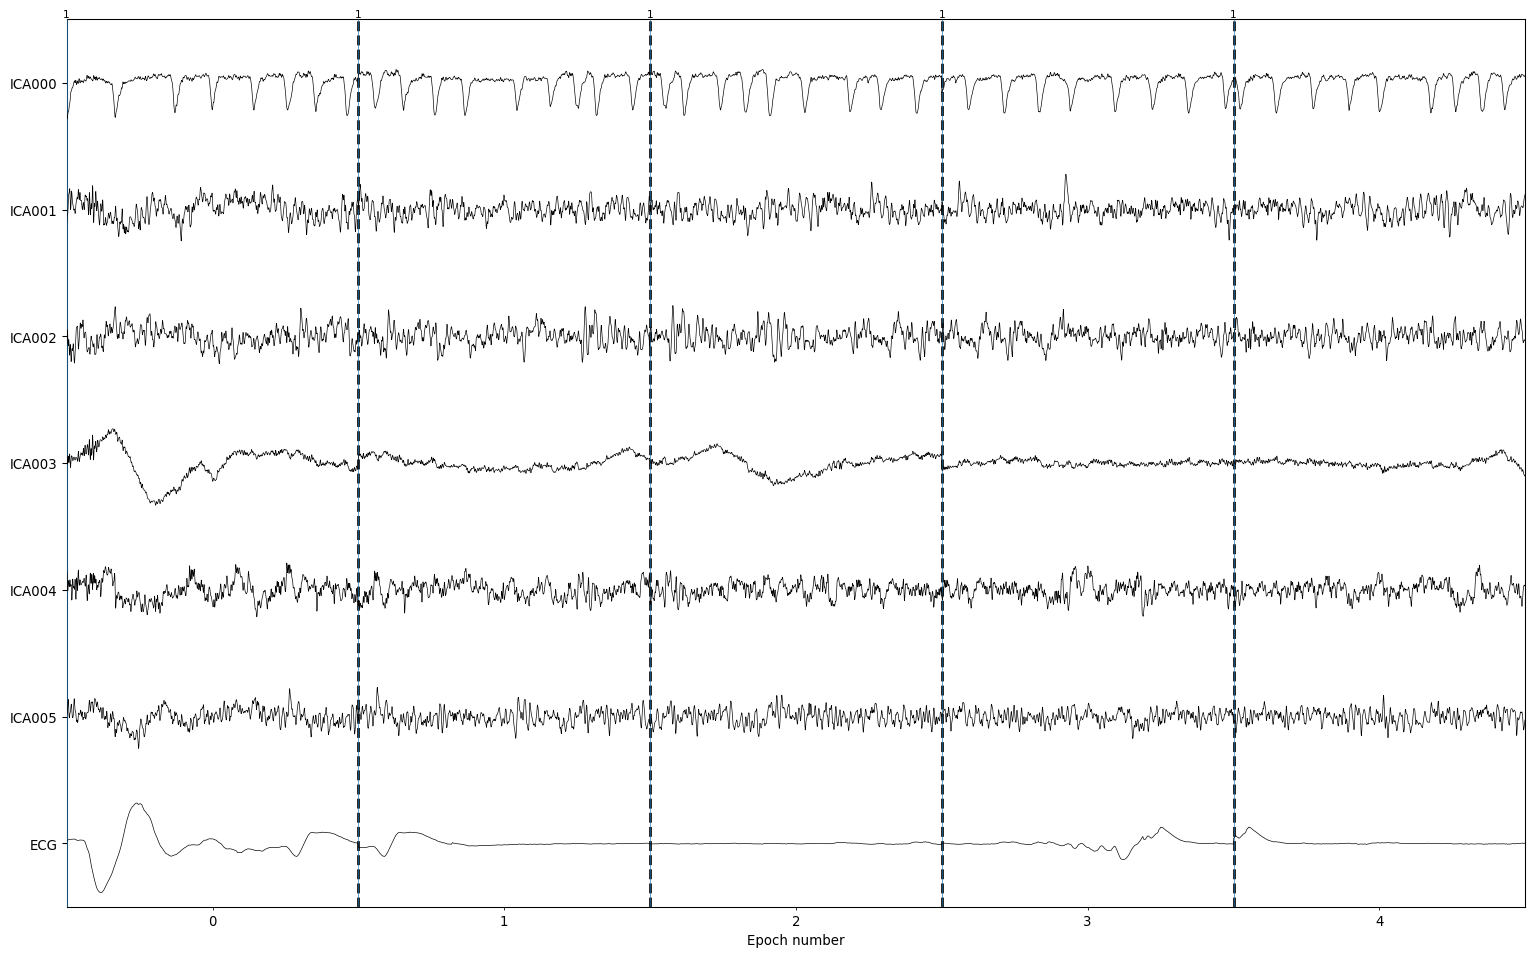

Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


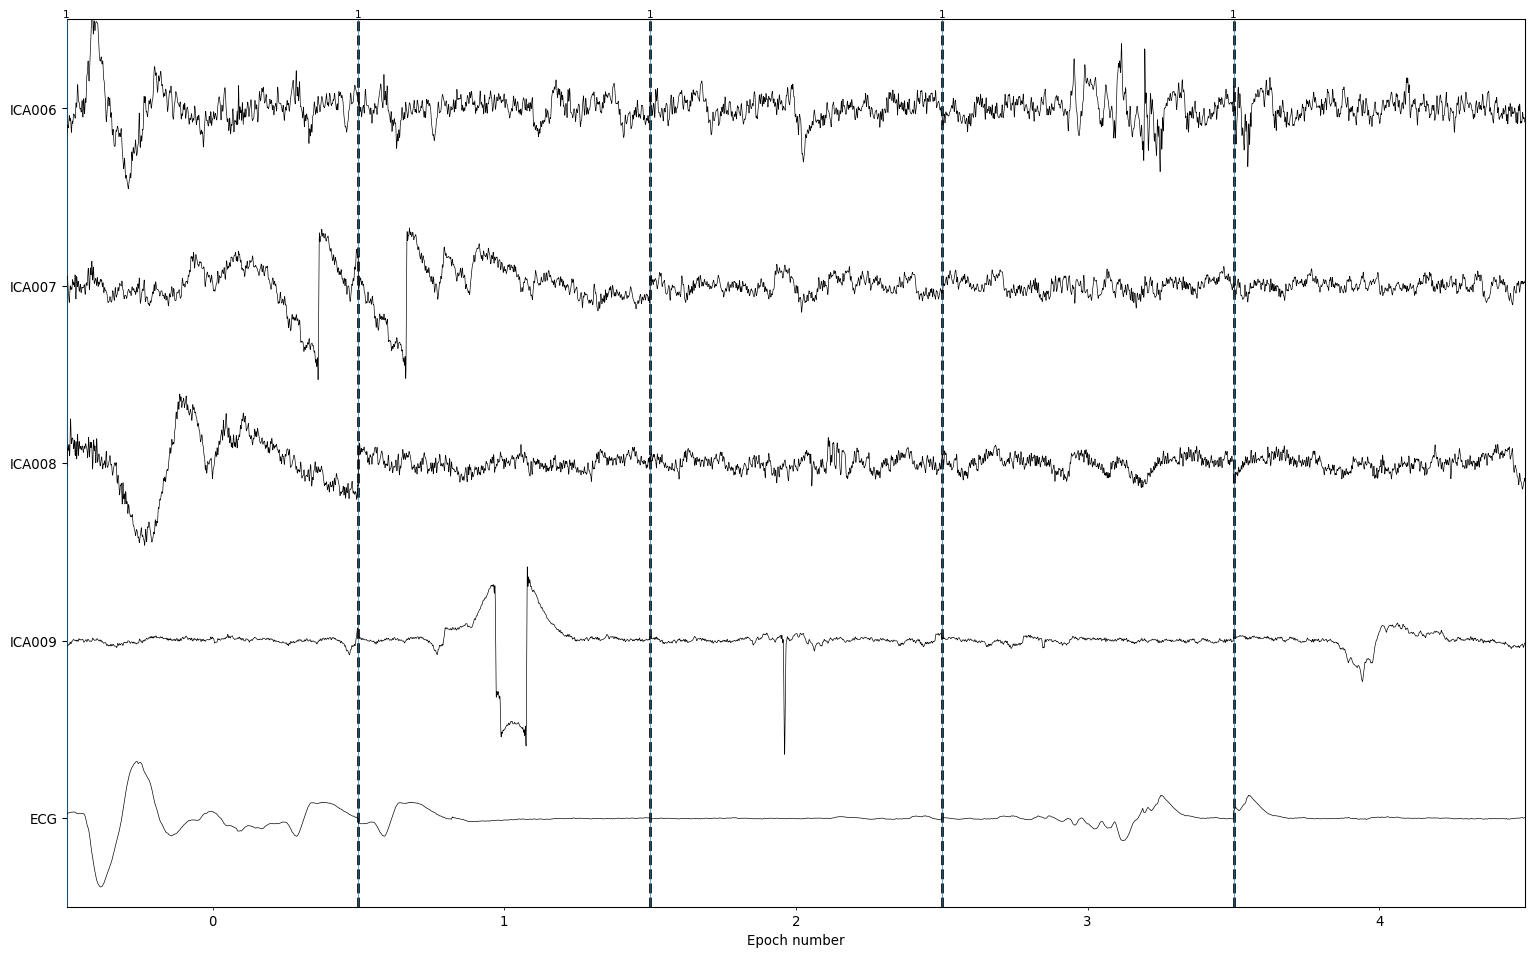

In [8]:
for chunk in chunks:
    ica_plot = ica.plot_sources(
        epochs_good,
        picks=chunk,
        show_scrollbars=False,
        start=0,
        stop=5,
    )

Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


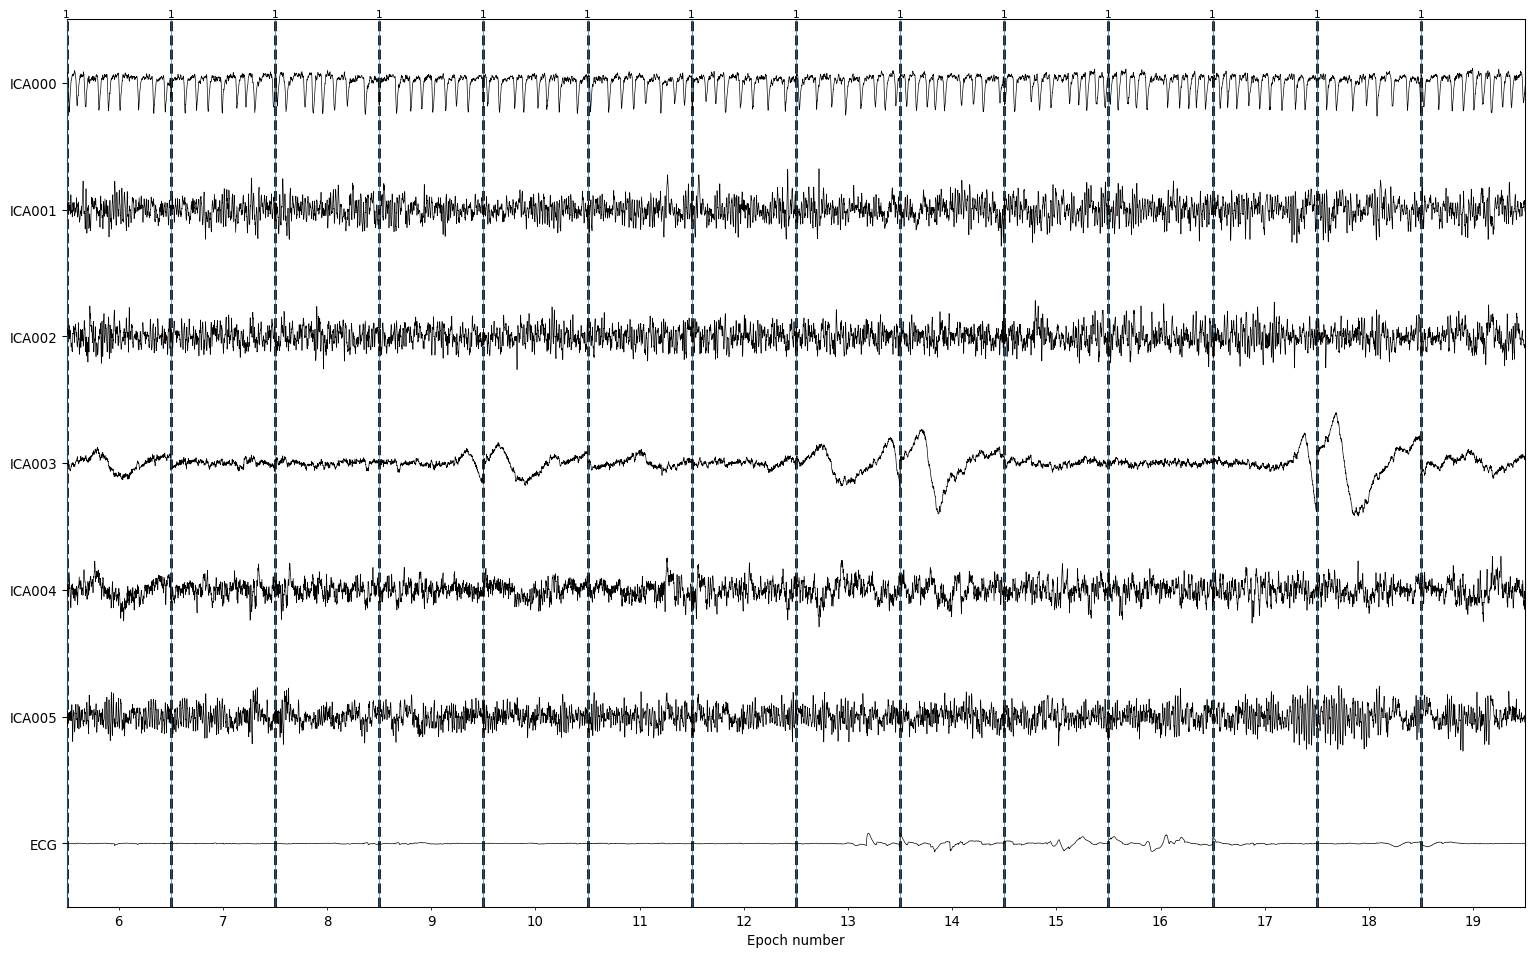

Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


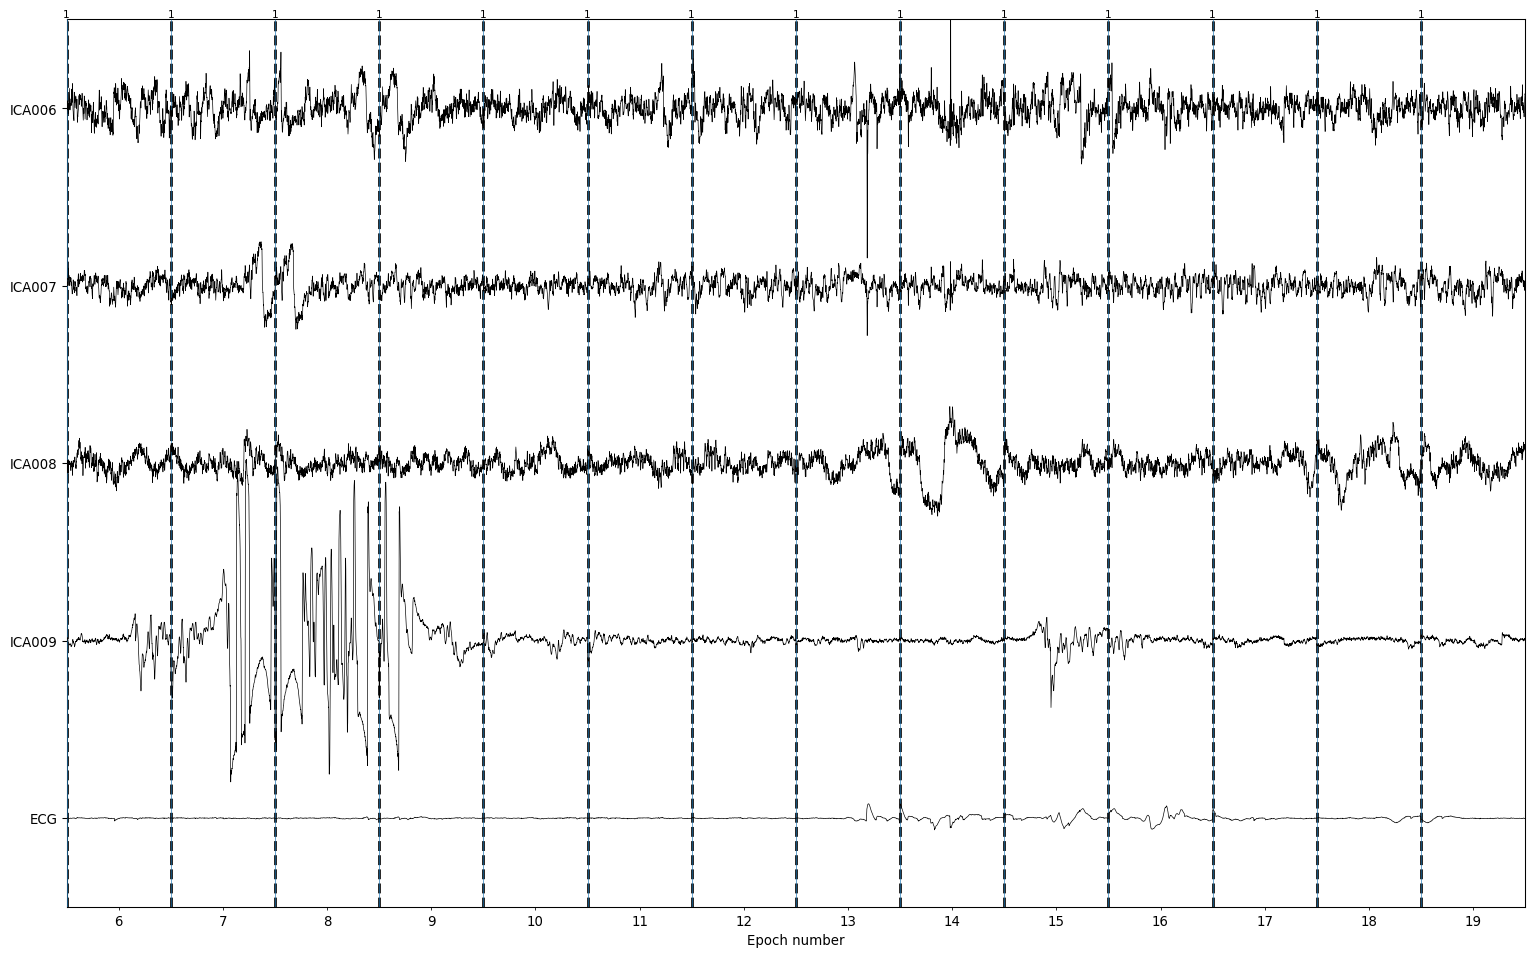

In [9]:
for chunk in chunks:
    ica_plot = ica.plot_sources(
        epochs_good,
        picks=chunk,
        show_scrollbars=False,
        start=6,
        stop=20,
    )

In [10]:
explained_var_ratio = ica.get_explained_variance_ratio(epochs_good)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {
            channel_type} variance explained by all components: "
        f"{ratio}"
    )

Fraction of eeg variance explained by all components: 0.990556439195253


# ICA label gui


In [11]:
from mne_icalabel.gui import label_ica_components

# gui = label_ica_components(epochs_good, ica)

# Removing components


In [12]:
ecg_indices, ecg_scores = ica.find_bads_ecg(
    clean_raw, method="correlation", threshold="auto"
)

try:
    # ica_plot = ica.plot_sources(eeg_data)
    # Exclude blink artifact components (use Fp1 as EOG proxy)

    # ica.exclude = np.argwhere(abs(eog_scores) > 0.5).ravel().tolist()
    _ = ica.plot_sources(
        epochs_good,
        show_scrollbars=False,
        picks=ecg_indices,
        start=0,
        stop=300.0,
    )
    _ = ica.plot_properties(epochs_good, picks=ecg_indices)
except Exception as e:
    # If an exception occurs, print the error message
    print("An error occurred:", e)

... filtering ICA sources


Setting up band-pass filter from 8 - 16 Hz


FIR filter parameters


---------------------


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hann window


- Lower passband edge: 8.00


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)


- Upper passband edge: 16.00 Hz


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)


- Filter length: 2500 samples (10.000 s)


... filtering target


Setting up band-pass filter from 8 - 16 Hz


FIR filter parameters


---------------------


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hann window


- Lower passband edge: 8.00


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)


- Upper passband edge: 16.00 Hz


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)


- Filter length: 2500 samples (10.000 s)


An error occurred: No appropriate components found for the given picks ([])


In [13]:
exclude = sorted([])
# exclude = sorted([0, 1, 2, 3, 11, 12, 14])
exclude = sorted([0, 3, 9])
ica.exclude = exclude
epochs_clean_manual = ica.apply(epochs_good.copy(), exclude=ica.exclude)
print(ica)

epochs_clean_manual.save(
    f"{project_path}/analysis/sub-{subject}_clean_ica-manual-epo.fif", overwrite=True
)

# Define a dictionary
my_dict = {
    "bad_channels": clean_raw.info["bads"],
    "bad_ica": exclude,
}
json_path = f"{project_path}/analysis/sub-{subject}_prepro_info_json"

# Save the dictionary to a JSON file
with open(json_path, "w") as f:
    json.dump(my_dict, f)

Applying ICA to Epochs instance


    Transforming to ICA space (10 components)


    Zeroing out 3 ICA components


    Projecting back using 196 PCA components


<ICA | epochs decomposition, method: picard (fit in 33 iterations on 106335 samples), 10 ICA components (196 PCA components available), channel types: eeg, 3 sources marked for exclusion>
Overwriting existing file.


Overwriting existing file.


    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


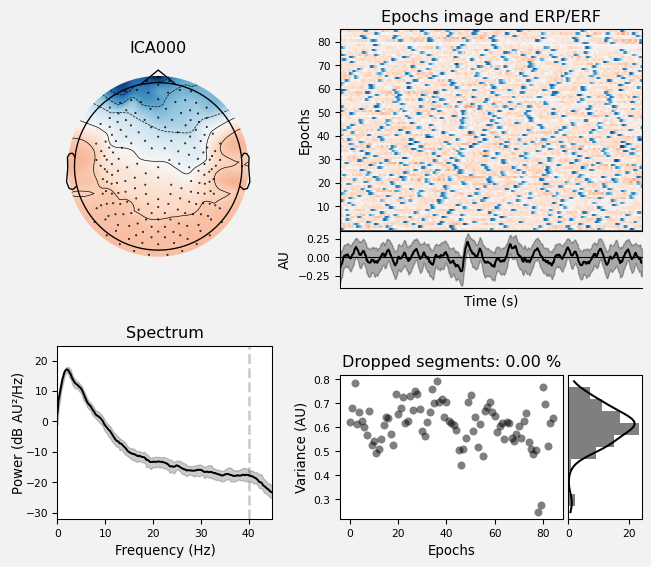

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


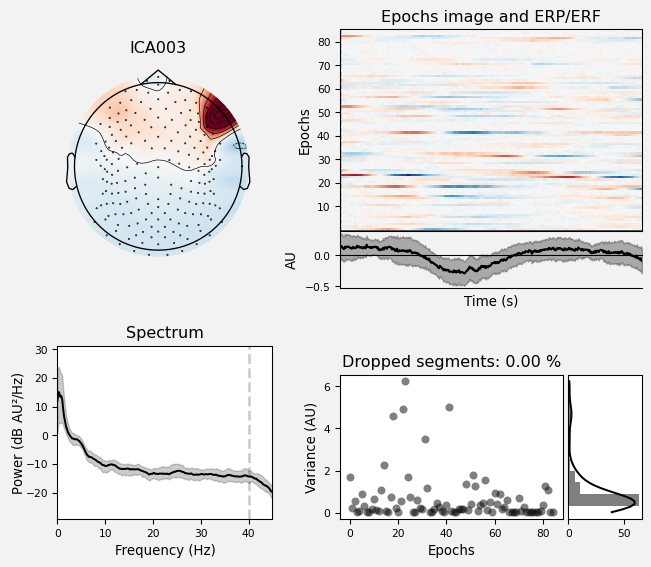

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


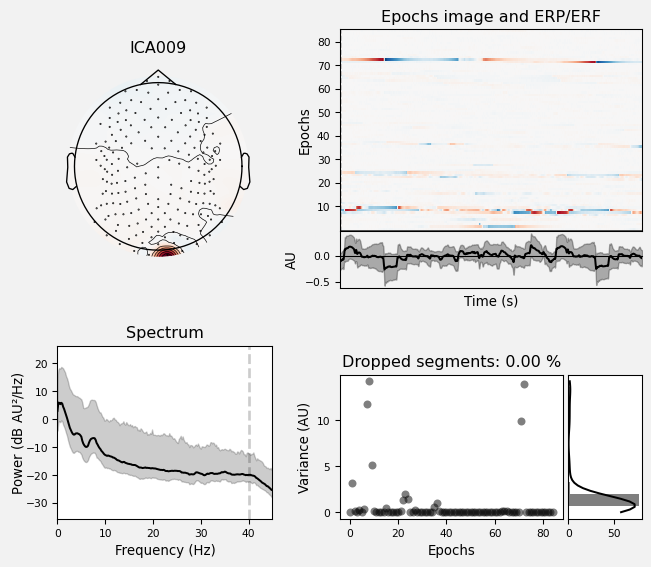

In [14]:
for component in sorted(exclude):
    ica_plot = ica.plot_properties(
        epochs_good, picks=component, psd_args={"fmax": 45.0}
    )

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


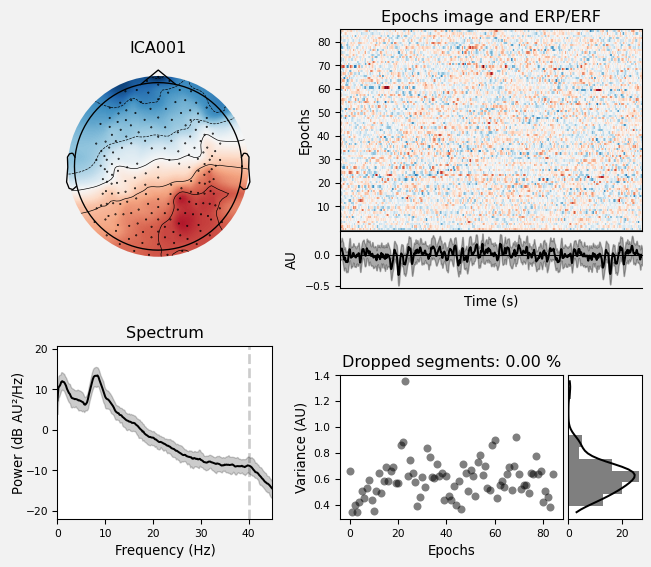

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


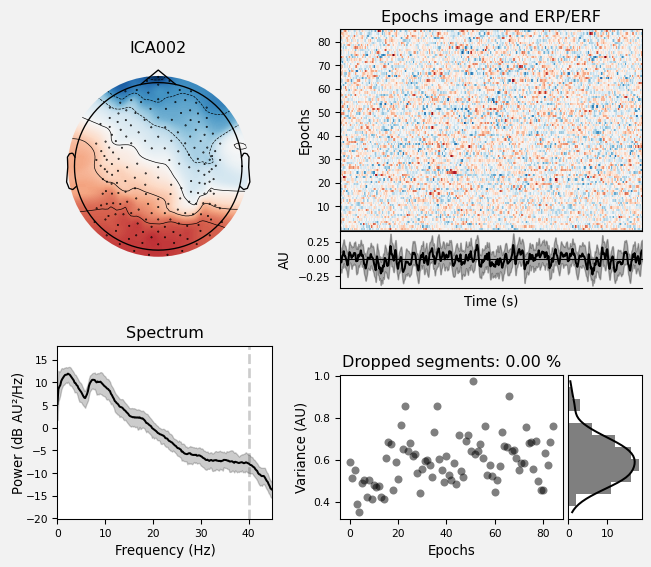

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


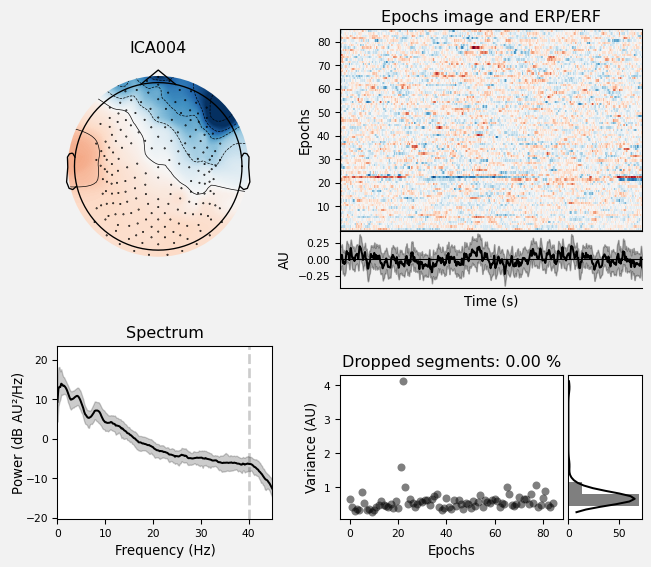

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


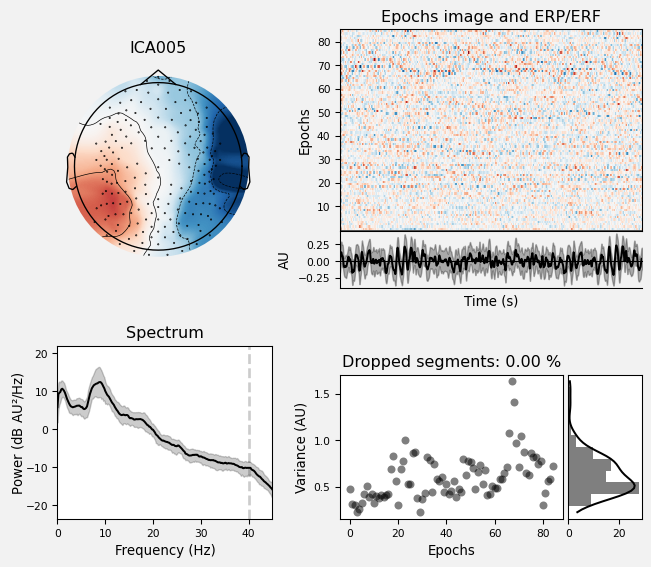

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


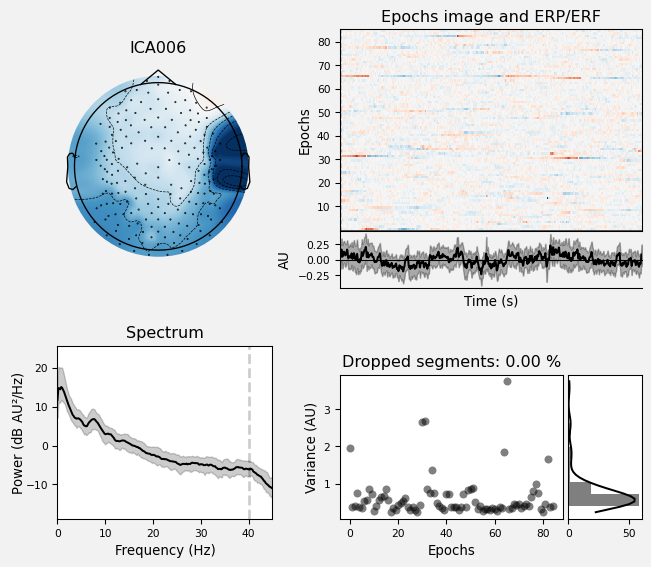

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


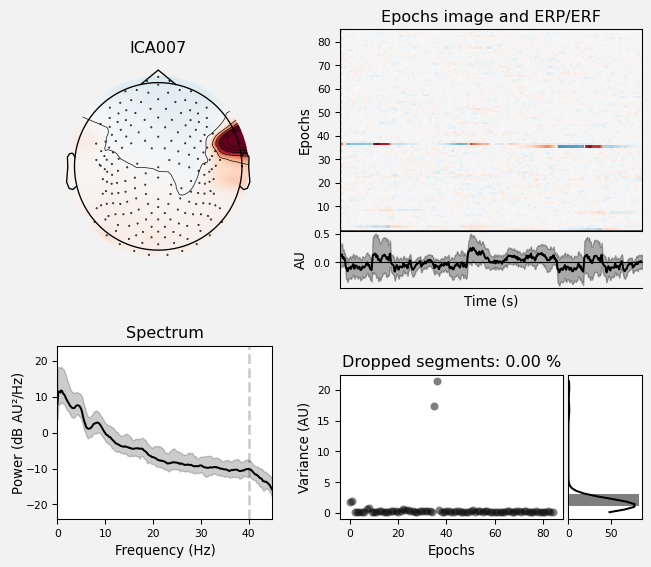

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


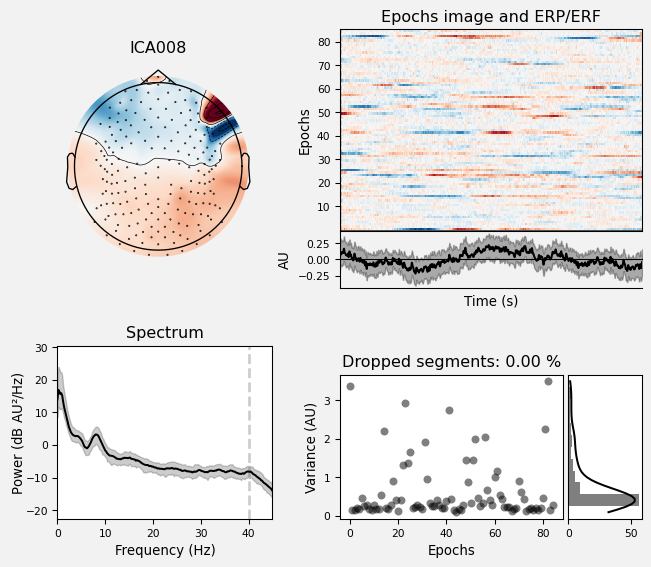

In [15]:
ica_indices = list(range(ica.n_components_))
good_components = [i for i in ica_indices if i not in exclude]
for component in sorted(good_components):
    ica_plot = ica.plot_properties(
        epochs_good, picks=component, psd_args={"fmax": 45.0}
    )

Applying ICA to Evoked instance


    Transforming to ICA space (10 components)


    Zeroing out 3 ICA components


    Projecting back using 196 PCA components


    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


Not setting metadata


85 matching events found


No baseline correction applied


0 projection items activated


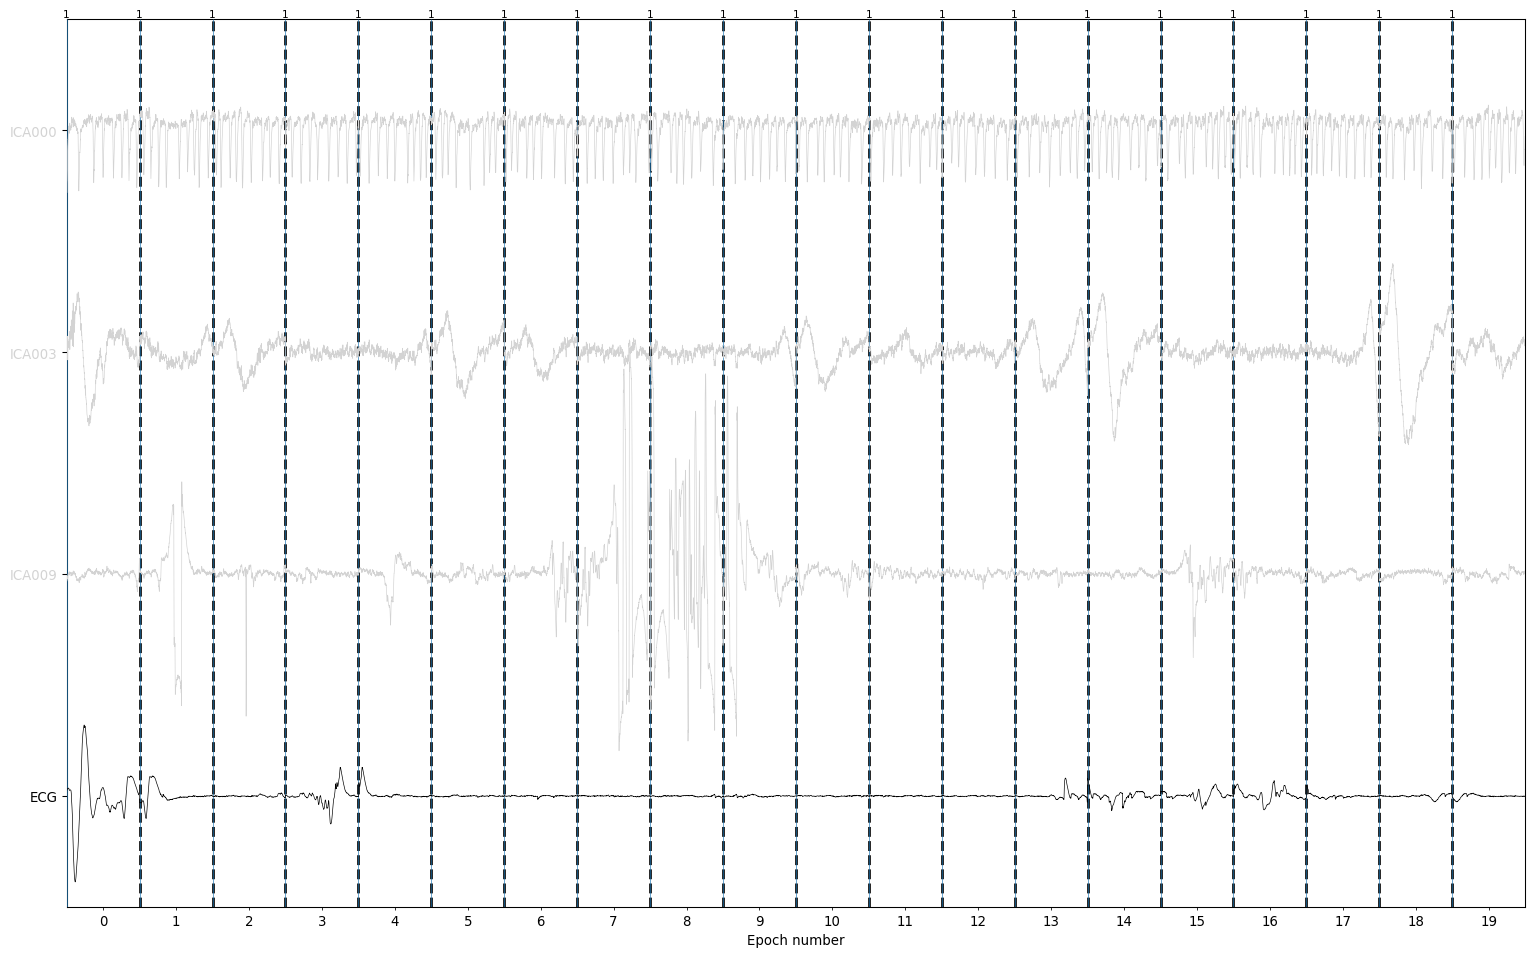

In [16]:
# Add location of bad channels
try:
    report.add_ica(
        ica=ica,
        title="ICA cleaning",
        picks=ica.exclude,  # plot the excluded EOG components
        inst=epochs_good,
    )
    # Add just sources of the removed components
    ica_figure_sources = ica.plot_sources(
        epochs_good, picks=exclude, show_scrollbars=False
    )
    report.add_figure(ica_figure_sources, title="ICA rejected components")

except Exception as e:
    # If an exception occurs, print the error message
    print("An error occurred:", e)

# ICA plot overlay


Applying ICA to Evoked instance


    Transforming to ICA space (10 components)


    Zeroing out 3 ICA components


    Projecting back using 196 PCA components


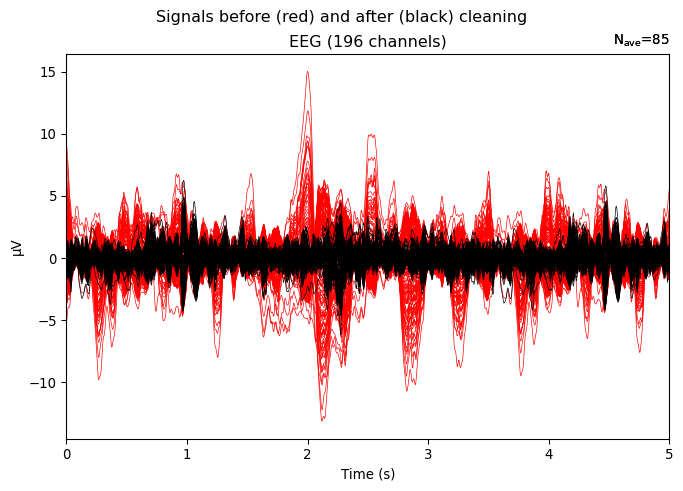

In [17]:
cleaned_plot = ica.plot_overlay(epochs_good.average())

No projector specified for this dataset. Please consider the method self.add_proj.


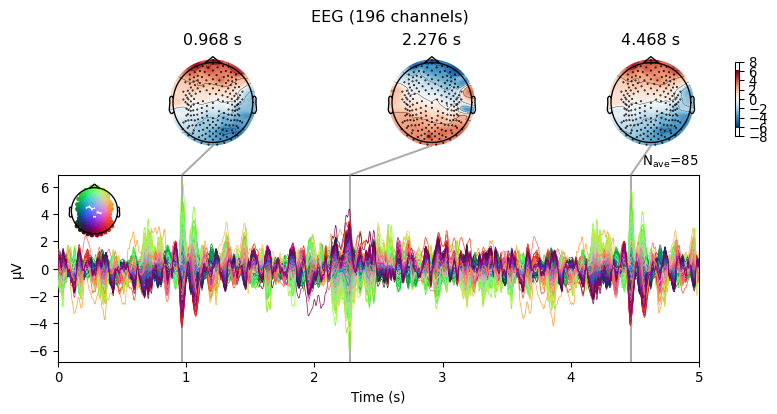

Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


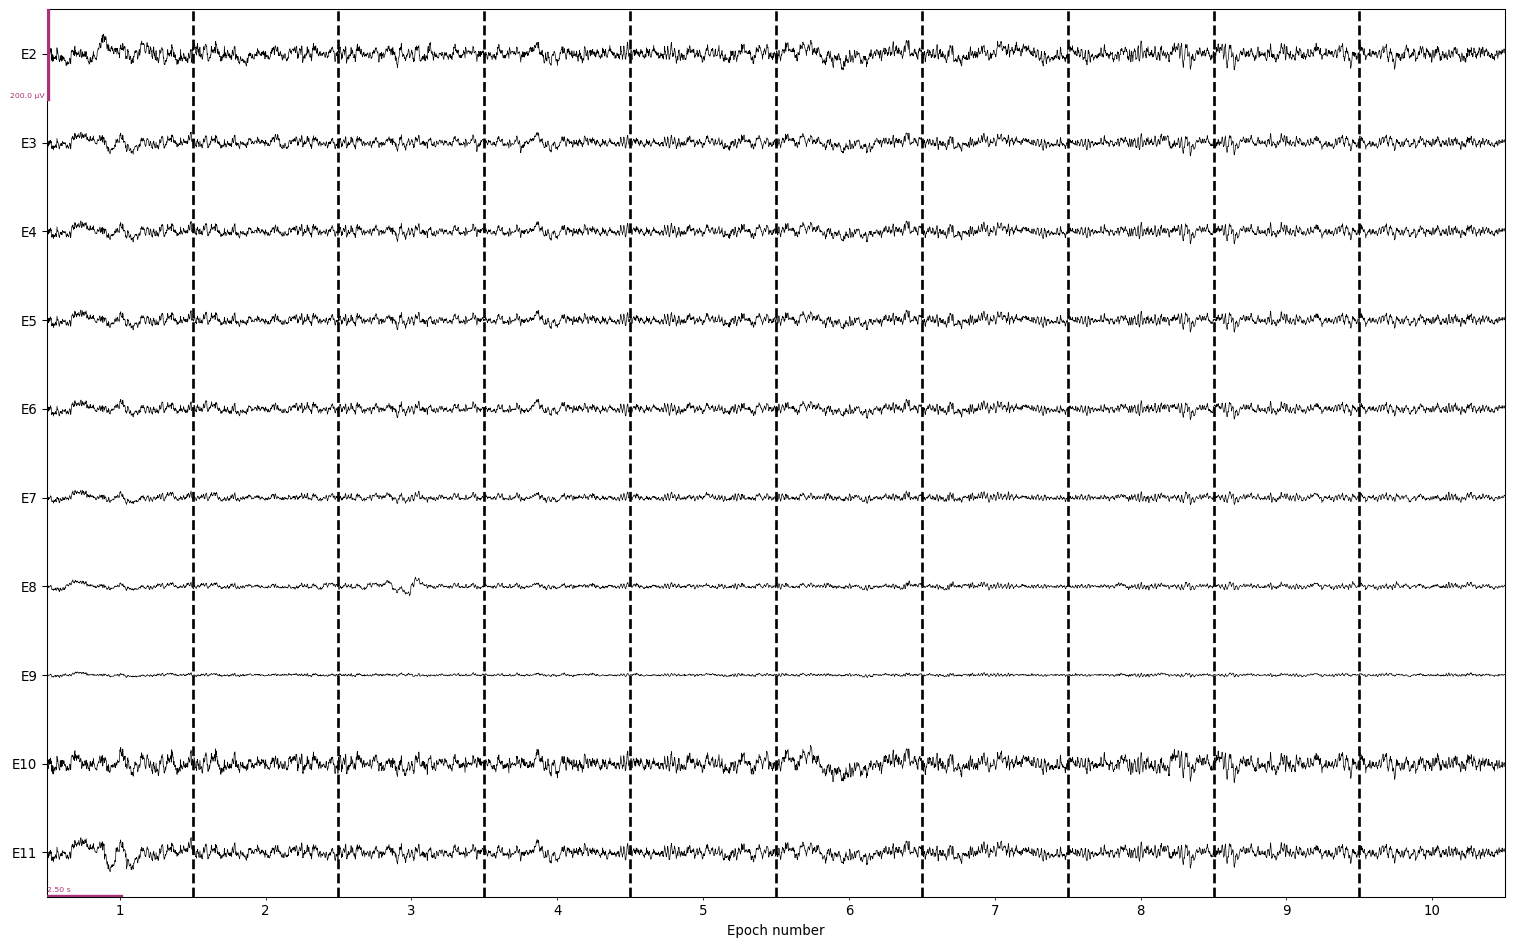

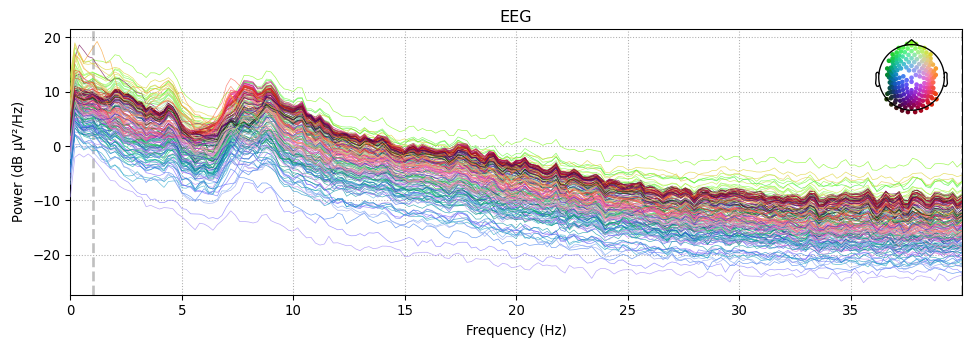

In [18]:
epochs_plot, epochs_plot_psd = plot_epochs(
    epochs_clean_manual, figures_path=figures_path, subject=subject, fmax=40.0
)
report.add_figure(epochs_plot, title="Cleaned epochs after ICA")
report.add_figure(epochs_plot_psd, title="Cleaned epochs after ICA - PSD")

In [19]:
ica.save(f"{project_path}/analysis/sub-{subject}_my_ica_model-ica.fif", overwrite=True)

Overwriting existing file.


Writing ICA solution to /Users/daniel/PhD/Projects/psd-path/analysis/sub-137_my_ica_model-ica.fif...


<ICA | epochs decomposition, method: picard (fit in 33 iterations on 106335 samples), 10 ICA components (196 PCA components available), channel types: eeg, 3 sources marked for exclusion>

# Final part of the analysis


In [20]:
ica_loaded = mne.preprocessing.read_ica(
    f"{project_path}/analysis/sub-{subject}_my_ica_model-ica.fif"
)

Reading /Users/daniel/PhD/Projects/psd-path/analysis/sub-137_my_ica_model-ica.fif ...


Now restoring ICA solution ...


Ready.


fitting finished


Dropped 34 epochs: 21, 22, 23, 24, 25, 26, 31, 32, 35, 36, 40, 43, 45, 48, 49, 54, 55, 56, 57, 58, 59, 60, 64, 65, 66, 68, 69, 70, 73, 74, 75, 77, 81, 82


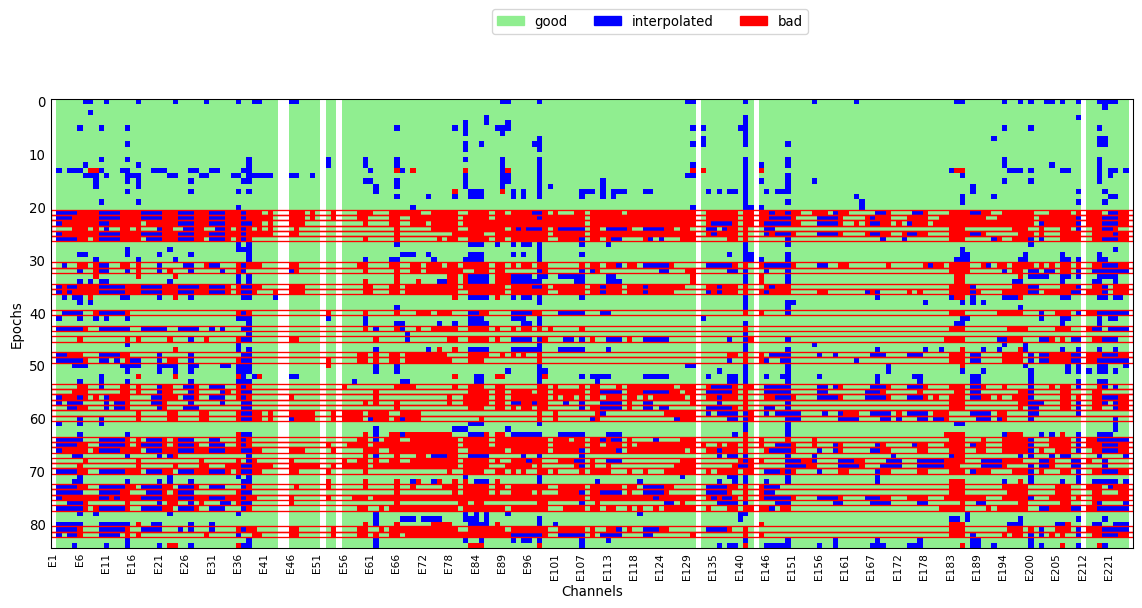

In [21]:
auto_reject_pre_ica = autoreject.AutoReject(
    n_interpolate=[1, 2, 4, 8, 32, 64],
    n_jobs=-1,
    random_state=100,
    thresh_method="bayesian_optimization",
    verbose=False,
    # n_interpolate=np.array([0]),
    # consensus=0.8,
).fit(epochs_clean_manual[:20])
print("fitting finished")
epochs_ar, reject_log = auto_reject_pre_ica.transform(
    epochs_clean_manual, return_log=True
)


# depending of the resampling - different number of epochs are rejected

reject_plot = reject_log.plot("vertical")
report.add_figure(reject_plot, title="Interpolated epochs - AutoReject overview")

# Add the last part to the report
report.add_figure(
    reject_plot, title="Autoreject - Rejected and interpolated epochs after ICA"
)

In [22]:
epochs_interpolated = epochs_ar.copy().interpolate_bads(exclude=["VREF"])
epochs_interpolated.save(
    f"{project_path}/analysis/sub-{subject}_interpolated-epo.fif", overwrite=True
)

Setting channel interpolation method to {'eeg': 'spline'}.


Interpolating bad channels.


    Automatic origin fit: head of radius 95.5 mm


Computing interpolation matrix from 196 sensor positions


Interpolating 8 sensors


No projector specified for this dataset. Please consider the method self.add_proj.


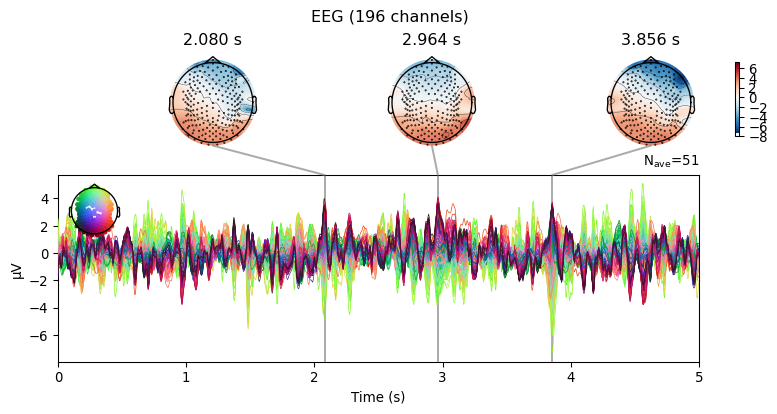

Effective window size : 5.004 (s)


Plotting power spectral density (dB=True).


Averaging across epochs...


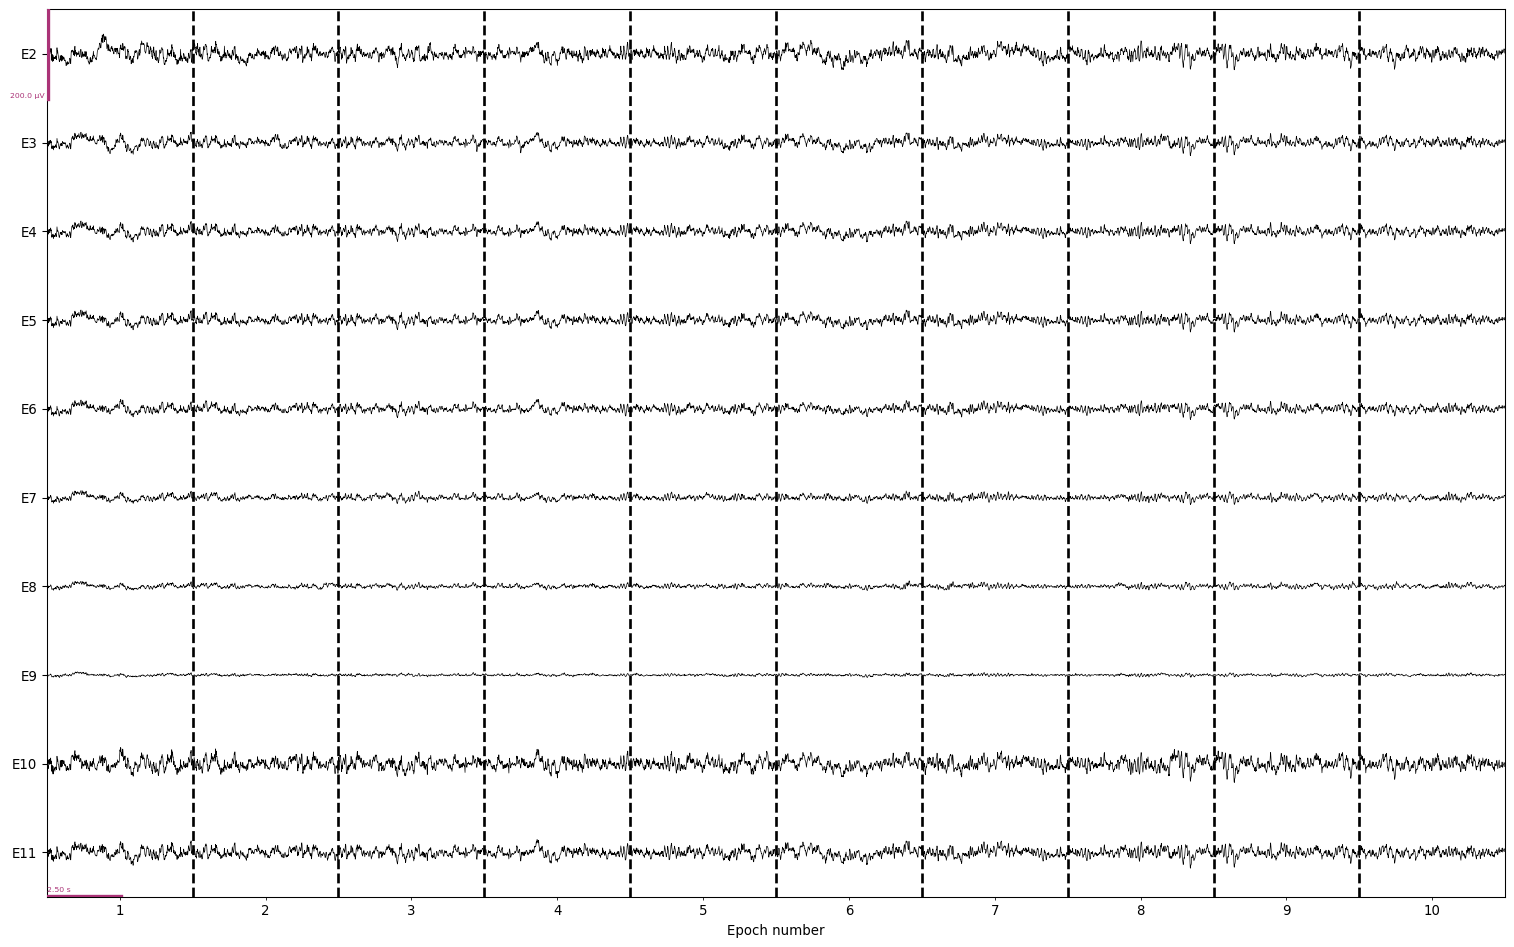

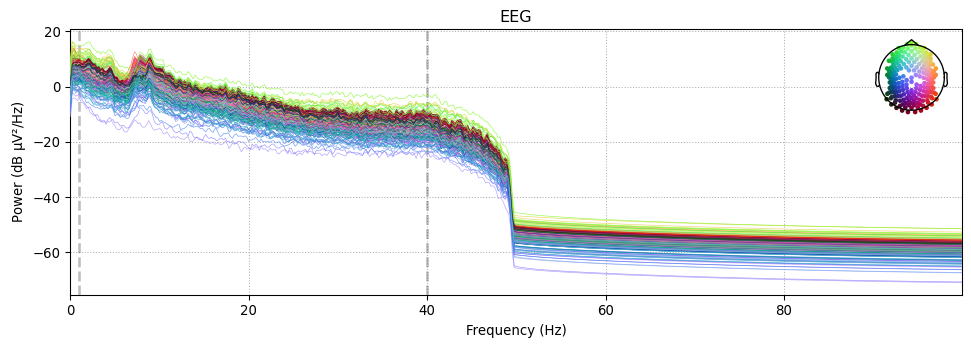

In [23]:
# epochs_interpolated
epochs_plot_interpolated, epochs_plot_psd_interpolated = plot_epochs(
    epochs_ar, figures_path, subject, stage="final_interpolared_epochs"
)
# Add figures to the report
report.add_figure(epochs_plot, title="Interpolated epochs")
report.add_figure(epochs_plot_psd, title="Interpolated epochs - PSD")

In [24]:
from specparam.plts.spectra import plot_spectra
from specparam import SpectralGroupModel


fg = SpectralGroupModel(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

    Using multitaper spectrum estimation with 7 DPSS windows


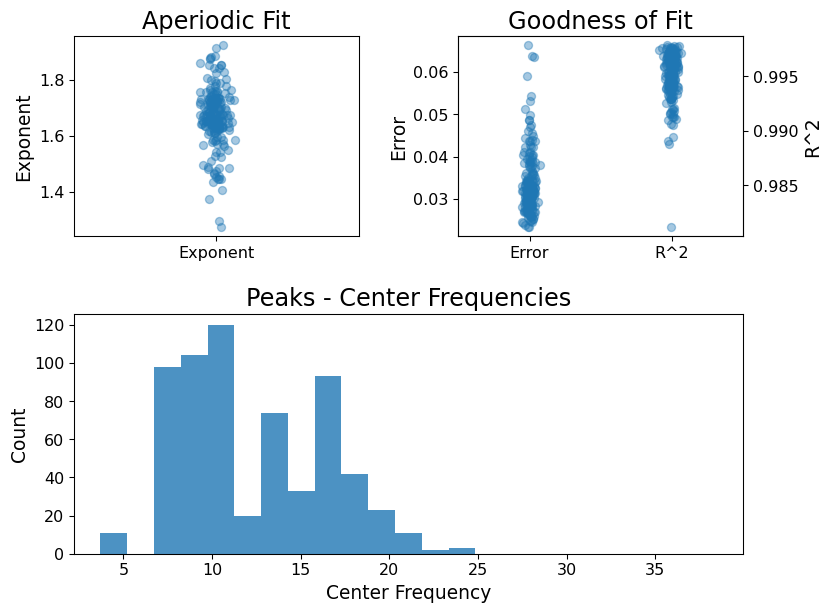

In [25]:
psd = epochs_ar.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 40]
fg.fit(freqs, spectra, freq_range)
fg.plot()

In [26]:
channel_names = epochs_ar.info["ch_names"]
df_channels = pd.DataFrame({"ID": range(len(channel_names)), "ch": channel_names})

df = specparam2pandas(fg)
df = df.merge(df_channels, on="ID")
df["sub_id"] = subject


# Get the current date and time
now = datetime.now()
df["timestamp"] = now
df["nr_intepolated_channels"] = len(epochs_ar.info["bads"])
df["nr_dropped_ica"] = len(ica.exclude)
df["nr_retained_ica"] = ica.n_components_ - len(ica.exclude)
# Create a new list of column names
cols = ["ch"] + [col for col in df.columns if col != "ch"]

# Reorder the columns
df = df[cols]

# Plot R and exponent across the scalp


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


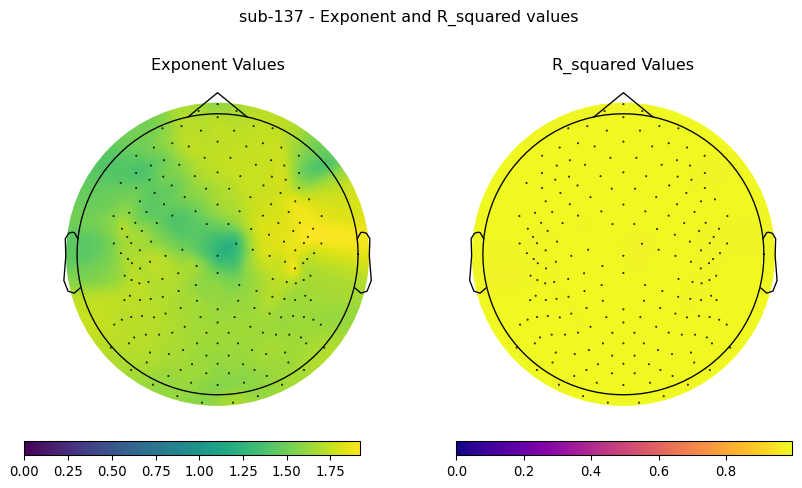

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import mne  # Make sure you have the MNE library installe


def exclude_bad_channels(epochs):
    """Modify to MNE object to exclude bad channels"""
    all_channels = epochs.info["ch_names"]
    bad_channels = epochs.info["bads"]
    good_channels = [ch for ch in all_channels if ch not in bad_channels]
    epochs_good = epochs.copy().pick_channels(good_channels)
    return epochs_good


epochs_ar_good = exclude_bad_channels(epochs_ar)

# Extract aperiodic exponent values
exps = fg.get_params("aperiodic_params", "exponent")
r_squared = fg.get_params("r_squared")

# Assuming 'exps' is your data array and 'raw' is an MNE raw object
# Also, assuming 'unit_label' and 'fontsize' variables are defined

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# The 'cmap' parameter expects a colormap object, not a string
im1, _ = mne.viz.plot_topomap(
    exps, epochs_ar_good.info, axes=axs[0], cmap="viridis", contours=0, show=False
)
axs[0].set_title("Exponent Values")

#  Colorbar setup for the first subplot at the bottom
cbar_ax1 = fig.add_axes([0.1, 0.05, 0.35, 0.03])
fig.colorbar(im1, cax=cbar_ax1, orientation="horizontal")


# Plot the 'errors' data in the second subplot
im2, _ = mne.viz.plot_topomap(
    r_squared,
    epochs_ar_good.info,
    axes=axs[1],
    cmap="plasma",
    contours=0,
    show=False,
)
axs[1].set_title("R_squared Values")

# Colorbar setup for the second subplot at the bottom
cbar_ax2 = fig.add_axes([0.55, 0.05, 0.35, 0.03])
fig.colorbar(im2, cax=cbar_ax2, orientation="horizontal")
fig.suptitle(f"sub-{subject} - Exponent and R_squared values")

plt.show()
report.add_figure(fig, title="Exponent and R_squared values")

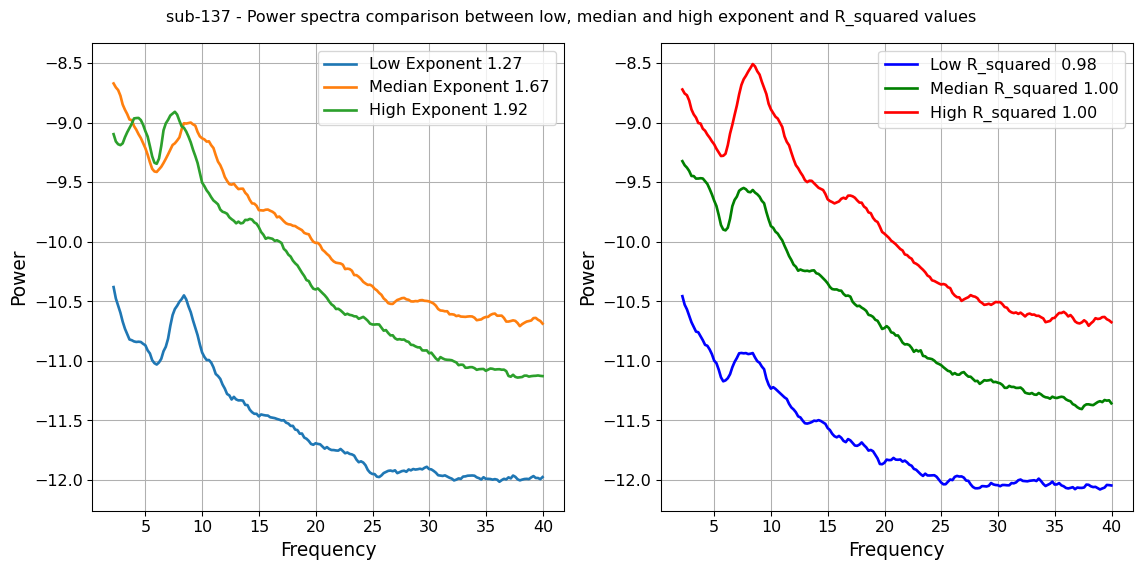

In [28]:
# Compare the power spectra between low and high exponent channels
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


def argmedian(arr):
    return np.argsort(arr)[len(arr) // 2]


spectra_exp = [
    fg.get_model(np.argmin(exps)).power_spectrum,
    fg.get_model(argmedian(exps)).power_spectrum,
    fg.get_model(np.argmax(exps)).power_spectrum,
]

labels_spectra_exp = [
    f"Low Exponent {format(np.min(exps), '.2f')}",
    f"Median Exponent {format(np.median(exps), '.2f')}",
    f"High Exponent {format(np.max(exps), '.2f')}",
]

plot_spectra(
    fg.freqs,
    spectra_exp,
    ax=ax[0],
    labels=labels_spectra_exp,
)

spectra_r_squared = [
    fg.get_model(np.argmin(r_squared)).power_spectrum,
    fg.get_model(argmedian(r_squared)).power_spectrum,
    fg.get_model(np.argmax(r_squared)).power_spectrum,
]


labels_spectra_r_squared = [
    f"Low R_squared  {format(np.min(r_squared), '.2f')}",
    f"Median R_squared {format(np.median(r_squared), '.2f')}",
    f"High R_squared {format(np.max(r_squared), '.2f')}",
]


my_colors = ["blue", "green", "red"]
plot_spectra(
    fg.freqs,
    spectra_r_squared,
    ax=ax[1],
    labels=labels_spectra_r_squared,
    colors=my_colors,
)
ylim1 = ax[0].get_ylim()
ylim2 = ax[1].get_ylim()
# Set the same limits on the y-axis for both plots
ax[0].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
ax[1].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
fig.suptitle(
    f"sub-{subject} - Power spectra comparison between low, median and high exponent and R_squared values"
)

report.add_figure(
    fig, title="Examples of spectra as a function of exponent and R_squared values"
)

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.0464, 1.2722                                         
                                                                                                  
                                       3 peaks were found:                                        
          

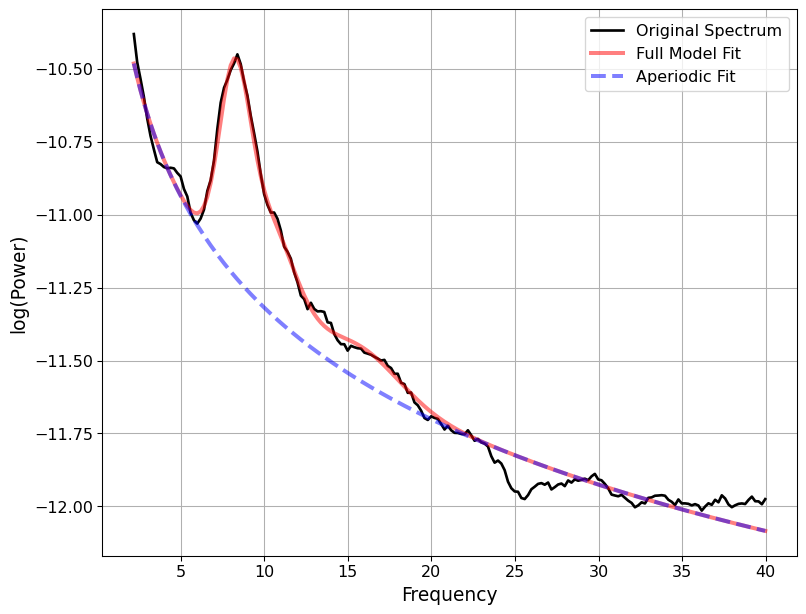

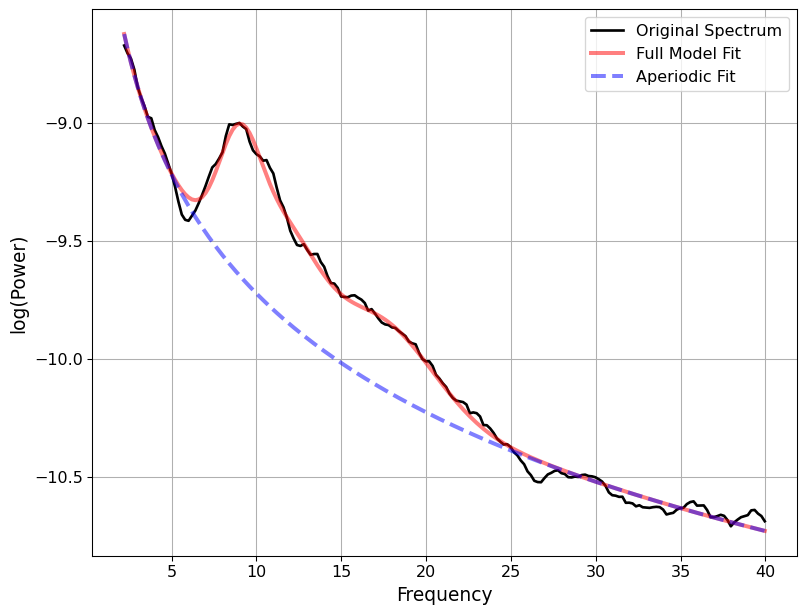

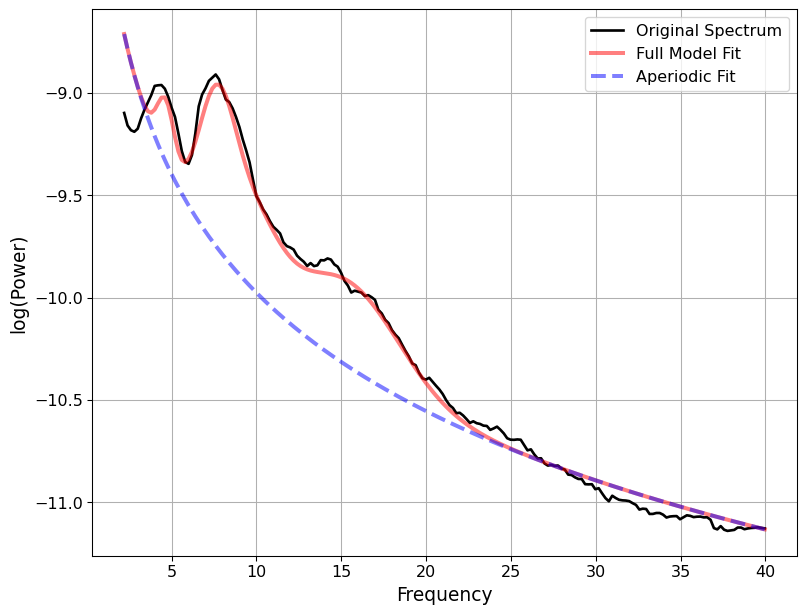

In [29]:
spectra_exp_fm = [
    fg.get_model(np.argmin(exps), regenerate=True),
    fg.get_model(argmedian(exps), regenerate=True),
    fg.get_model(np.argmax(exps), regenerate=True),
]
for fm, label in zip(spectra_exp_fm, labels_spectra_exp):
    # fm = fg.get_fooof(ind=2, regenerate=True)
    # Print results and plot extracted model fit
    fm.print_results()
    fm.plot()
    print(label)

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.0909, 1.2952                                         
                                                                                                  
                                       1 peaks were found:                                        
          

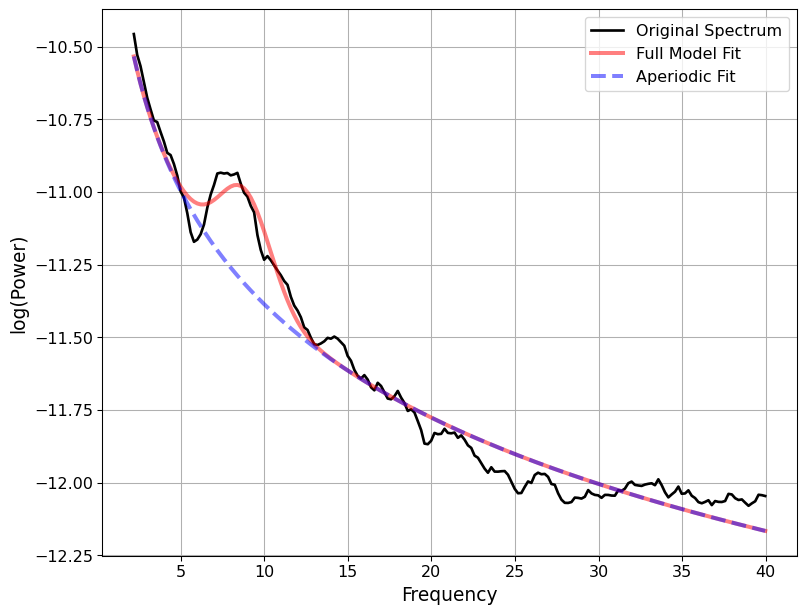

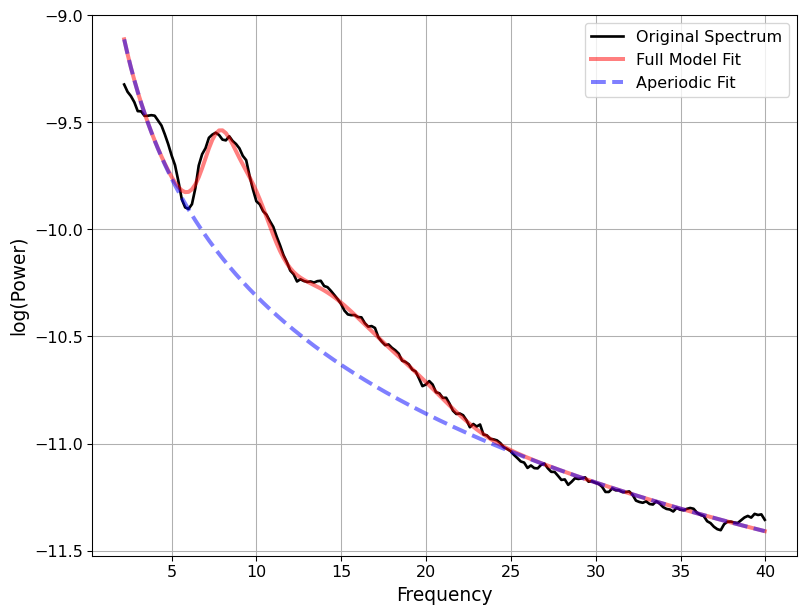

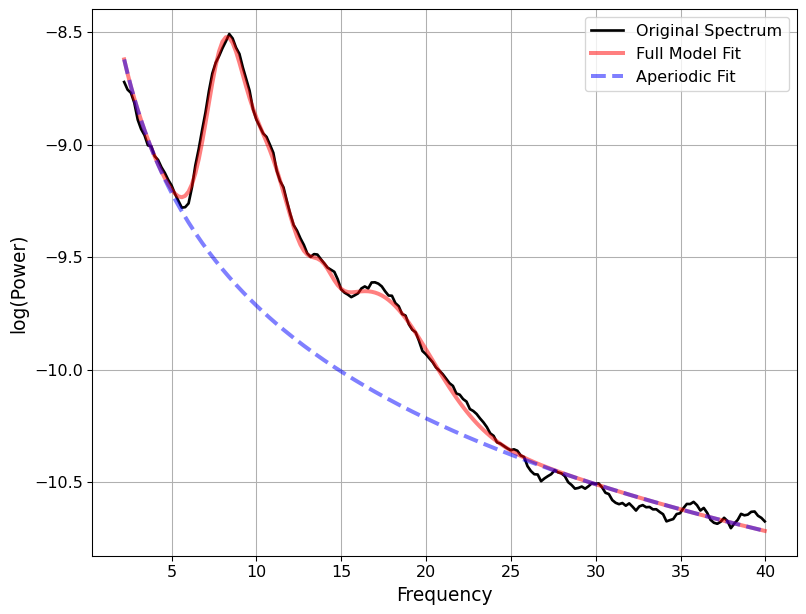

In [30]:
spectra_r_squared_fm = [
    fg.get_model(np.argmin(r_squared), regenerate=True),
    fg.get_model(argmedian(r_squared), regenerate=True),
    fg.get_model(np.argmax(r_squared), regenerate=True),
]

for fm, label in zip(spectra_r_squared_fm, labels_spectra_r_squared):
    # fm = fg.get_fooof(ind=2, regenerate=True)
    # Print results and plot extracted model fit
    fm.print_results()
    fm.plot()
    print(label)

In [31]:
df.to_csv(f"{specparam_path}/sub-{subject}-specparam.csv", index=False)
print(f"Subject {subject} done")

Subject 137 done


In [32]:
report.save(
    f"{project_path}/analysis/reports/sub-{subject}_report.html", overwrite=True
)

Saving report to : /Users/daniel/PhD/Projects/psd-path/analysis/reports/sub-137_report.html


'/Users/daniel/PhD/Projects/psd-path/analysis/reports/sub-137_report.html'